<a href="https://colab.research.google.com/github/szilaard/AIT_project/blob/main/AitProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIT Deep Learning Project - Music genre classification based on audio

Péter Czumbel, Szilárd Horváth


In [1]:
import tensorflow as tf
import librosa
import pandas as pd
from glob import glob
from IPython.display import display
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.utils import to_categorical
from random import shuffle

## 1. Exploring the data

We are using the GTZAN dataset, which consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks are all 22050Hz Mono 16-bit audio files in .wav format. However, downloading the GTZAN dataset from tensorflow datasets doesn't work, the URL times out, 
(see: https://github.com/tensorflow/datasets/issues/4090), therefore we are using [this](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) version of the dataset from kaggle instead.<br>
After downloading the dataset from Kaggle, extract the Data folder and place it into the projects root directory, if you wish to run the notebook yourself.



### 1.1 Loading the dataset

To download the dataset from kaggle, run the block below and upload your own kaggle API key

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
! unzip gtzan-dataset-music-genre-classification.zip

First we read all the data from the directories:

In [180]:
audio_files = glob("Data/genres_original/*/*.wav")

Setting some variables based on the dataset description:

In [181]:
sample_rate = 22050   # sampling frequency
duration = 30         # length of the tracks in seconds

### 1.2 Examples

There are 100 tracks of each genre, and our dataset is ordered, so if we check every 100th track, we can see all the different genres.<br>
Example track for each genre:

In [ ]:
for i in range(10):
    print(audio_files[i*100].split("\\")[1])
    display(Audio(audio_files[i*100]))

### 1.3 Plotting the waveforms

Plotting the waveforms of different music genres, we can see that classifying most of the genres would probably be possible even by only using the waveform, however some genres, like country and metal can look quite similar. 

In [ ]:
fig = plt.figure(figsize=(20, 7))
fig.tight_layout()
rows = 2
columns = 5
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    signal, sr = librosa.load(audio_files[(i-1)*100], sr=sample_rate)
    librosa.display.waveshow(signal, sr=sample_rate)
    plt.title(audio_files[(i-1)*100].split("\\")[1])
    plt.xlabel("")
plt.show()


### 1.4 Plotting the MFCCs

Setting variables for calculating the MFCCs:

In [182]:
n_fft = 2048          # number of samples per fft - the size of the window when performing an fft
n_mfcc = 13           # number of extracted coefficients
hop_length = 512      # the amount we shift with each fft

Plotting the MFCCs of different genres yields more easily differentiable data for each genre. We will be using this version of the data to train our deep neural network.

In [ ]:
fig = plt.figure(figsize=(20, 7))
fig.tight_layout()
rows = 2
columns = 5
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    signal, sr = librosa.load(audio_files[(i-1)*100], sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    librosa.display.specshow(mfcc, sr=sample_rate, hop_length=hop_length)
    plt.title(audio_files[(i-1)*100].split("\\")[1])
plt.show()

## 2. Preprocessing the dataset

### 2.1 Splitting the tracks to segments and calculating MFCCs

We create a data structure for the mappings, the raw mfcc data and the labels. This way we can save the preprocessed data as a JSON file later.

In [183]:
data = {
    "mapping": [],  # mapping the names of the genres to indexes 0 to 9
    "mfcc": [],     # array containing the mfcc arrays of the track segments
    "labels": []    # array of the genre labels of the track segments
}   

We define these parameters so we can finetune them if needed in the future. These parameters are needed so we will get uniform shape outputs after the sampling and the transformation.

In [6]:
number_of_segments = 10      # the number of segments we want to split each track
samples_per_track = sample_rate * duration  # how many samples do we get from each track
samples_per_segment=int(samples_per_track/number_of_segments)    # how many samples are there in a segment
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)   # this is to check if the output has the correct dimensions

For the next part we separate our audio data into segments, then we use mel frequency cepstral coefficients (MFCCs) on them. This transforms our data closer to what humans would hear/notice listening to the music.

In [185]:
shuffle(audio_files)    # the audio files are ordered by category, its easier to shuffle them here while we only have to shuffle one array
for audio_file in audio_files:
    # cutting the name of the genre from the filename
    genre = audio_file.split("\\")[1]
    # adding genre to mapping if its not already there
    if genre not in data["mapping"]:      
        data["mapping"].append(genre) 
    try:
        # reading signal and sample rate from the file
        signal, sr = librosa.load(audio_file) 
    except:
        #there are some corrupted/non readable files so we dont process them
        continue
        
    # we dont have much data, so we split the tracks into segments to increase our training data
    for i in range(number_of_segments):
        # calculating start and finish index of the segment
        start = samples_per_segment * i
        end = start + samples_per_segment
        # Calculating the mfcc of the segment
        mfcc = librosa.feature.mfcc(y=signal[start:end], sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T
        # Some tracks are shorter than 30 seconds, so we have segments with incorrect length. We filter those out here
        if len(mfcc) == num_mfcc_vectors_per_segment:
            # Adding the mfcc and label to our data
            data["mfcc"].append(mfcc)
            data["labels"].append(data["mapping"].index(genre))

C:\Users\pczum\AppData\Local\Temp\ipykernel_28488\3083834638.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(audio_file)
d:\programs\anaconda3\envs\ait\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


We transform the created lists into numpy arrays, so they are easier to handle.

In [186]:
data["mfcc"] = np.array(data["mfcc"], dtype=np.float32)
data["labels"] = np.array(data["labels"], dtype=np.float32)

In [189]:
data["mfcc"] = data["mfcc"].reshape(data["mfcc"].shape[0], 65, 26, 1)

### 2.3 Splitting training, testing and validation data

We separate our data into training, validation and test datasets, we define the ratios so we can fine tune them later.

In [191]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

train_size = int(train_ratio*data_length)
valid_size = int(valid_ratio*data_length)
test_size = int(test_ratio*data_length)

X_train = data["mfcc"][:train_size]
Y_train = data["labels"][:train_size]
X_valid = data["mfcc"][train_size:train_size+valid_size]
Y_valid = data["labels"][train_size:train_size+valid_size]
X_test = data["mfcc"][train_size+valid_size:]
Y_test = data["labels"][train_size+valid_size:]


### 2.3 Standardization

We calculate the mean and variance of the training data, then use these values to standerdize the whole dataset.

In [192]:
X_train=np.asarray(X_train)
Y_train=np.asarray(Y_train)
X_valid=np.asarray(X_valid)
Y_valid=np.asarray(Y_valid)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

In [193]:
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0, dtype=np.float32)

In [194]:
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test  = (X_test - mean) / std

### 2.4 Encoding the labels and performing checks

We check if each data set has the same number of categories in the output.

In [195]:
nb_classes = len(np.unique(Y_train))
print("Validation data has the same number of classes, as the training data:", nb_classes == len(np.unique(Y_valid)))
print("Test data has the same number of classes, as the training data:", nb_classes == len(np.unique(Y_test)))

Validation data has the same number of classes, as the training data: True
Test data has the same number of classes, as the training data: True


We change the dense representation of the classes to one-hot encoding.

In [196]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

Final check if the data has the right shape, mean and standard deviation.

In [197]:
print("Shapes of the training, validation and test input data:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes of the training, validation and test output data:", Y_train.shape, Y_valid.shape, Y_test.shape)
print("Mean values of the training, validation and test input data:", X_train.mean(), X_valid.mean(), X_test.mean())
print("Standard deviation of the training, validation and test input data:", X_train.std(), X_valid.std(), X_test.std())

Shapes of the training, validation and test input data: (6990, 65, 26, 1) (1997, 65, 26, 1) (999, 65, 26, 1)
Shapes of the training, validation and test output data: (6990, 10) (1997, 10) (999, 10)
Mean values of the training, validation and test input data: 1.3239758e-09 0.011075033 0.019788973
Standard deviation of the training, validation and test input data: 1.0000005 0.9772907 1.0139227


In [198]:
X_train = np.array([np.array(val) for val in X_train])
Y_train = np.array([np.array(val) for val in Y_train])

X_train = tf.cast(X_train , dtype=tf.float32)
Y_train = tf.cast(Y_train , dtype=tf.float32)

# 3. Models
For models we decided to use...

### 3.1 CNN

In [223]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l1, l2

In [252]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [258]:
input = Input(shape=(X_train.shape[1:]))
conv1 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(input)
conv2 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(conv1)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv2)
ap = BatchNormalization()(ap)
conv3 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv3)
ap = BatchNormalization()(ap)
conv4 = Conv2D(filters=512, kernel_size=4, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
ap = GlobalAveragePooling2D()(conv4)
dense1 = Dense(256, activation='relu')(ap)
dense1 = Dropout(0.1)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
output = Dense(nb_classes, activation='softmax')(dense2)
conv_model = tf.keras.Model(inputs=input, outputs=output)


In [259]:
conv_model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 65, 26, 1)]       0         
                                                                 
 conv2d_305 (Conv2D)         (None, 63, 24, 256)       2560      
                                                                 
 conv2d_306 (Conv2D)         (None, 61, 22, 256)       590080    
                                                                 
 average_pooling2d_82 (Avera  (None, 31, 11, 256)      0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_118 (Ba  (None, 31, 11, 256)      1024      
 tchNormalization)                                               
                                                                 
 conv2d_307 (Conv2D)         (None, 29, 9, 256)        590

In [260]:
conv_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [261]:
conv_model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=1, callbacks=es)

Epoch 1/50
437/437 [==============================] - 7s 16ms/step - loss: 1.5694 - accuracy: 0.4562 - val_loss: 1.3484 - val_accuracy: 0.5188
Epoch 2/50
437/437 [==============================] - 7s 15ms/step - loss: 1.1724 - accuracy: 0.5848 - val_loss: 1.1628 - val_accuracy: 0.6119
Epoch 3/50
437/437 [==============================] - 6s 15ms/step - loss: 0.9584 - accuracy: 0.6661 - val_loss: 1.1552 - val_accuracy: 0.6179
Epoch 4/50
437/437 [==============================] - 6s 15ms/step - loss: 0.8316 - accuracy: 0.7070 - val_loss: 1.1182 - val_accuracy: 0.6440
Epoch 5/50
437/437 [==============================] - 6s 15ms/step - loss: 0.7018 - accuracy: 0.7548 - val_loss: 1.2484 - val_accuracy: 0.6340
Epoch 6/50
437/437 [==============================] - 6s 15ms/step - loss: 0.5885 - accuracy: 0.7963 - val_loss: 1.3175 - val_accuracy: 0.6535
Epoch 7/50
437/437 [==============================] - 6s 14ms/step - loss: 0.4659 - accuracy: 0.8411 - val_loss: 1.1672 - val_accuracy: 0.6760

32/32 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.56      0.56      0.56       130
           1       0.52      0.61      0.57        70
           2       0.59      0.16      0.25       120
           3       0.68      0.63      0.65       100
           4       0.69      0.95      0.80        80
           5       0.68      0.71      0.70       139
           6       0.47      0.74      0.58        80
           7       0.92      0.88      0.90        80
           8       0.70      0.71      0.70        90
           9       0.76      0.79      0.78       110

    accuracy                           0.65       999
   macro avg       0.66      0.67      0.65       999
weighted avg       0.66      0.65      0.64       999



<Axes: >

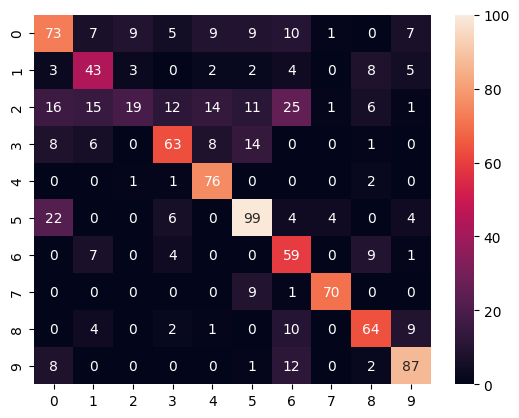

In [262]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
preds = conv_model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [266]:
conv.save(filepath="./models/",save_format="tf")

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets
